# Logisitc regression using lending club data

### In this note book I will be using lending club data to estimate a logistic 

In [2]:
# import packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

In [8]:
# read data and print it to see what we're working with
train = pd.read_excel("lendingclub_traindata.xlsx")
print(train.head())
print("-------------------------------------------")

validation = pd.read_excel("lendingclub_valdata.xlsx")
validation.rename(columns={'homw_ownership':'home_ownership'},inplace=True)
print(validation.head())
print("-------------------------------------------")

test = pd.read_excel("lendingclub_testdata.xlsx")
print(test.head())


   home_ownership    income    dti  fico  loan_status
0               1   44304.0  18.47   690            0
1               0   50000.0  29.62   735            1
2               0   64400.0  16.68   675            1
3               0   38500.0  33.73   660            0
4               1  118000.0  26.66   665            1
-------------------------------------------
   home_ownership    income    dti  fico  loan_status
0               0   25000.0  27.60   660            0
1               0   50000.0  21.51   715            1
2               1  100000.0   8.14   770            1
3               0   75000.0   1.76   685            0
4               1   78000.0  16.11   680            1
-------------------------------------------
   home_ownership    income    dti  fico  loan_status
0               1   52400.0  24.64   665            1
1               1  150000.0  17.04   785            1
2               1  100000.0  20.92   710            1
3               0   97000.0  13.11   705        

### The data has already been split into training set, validation set, and test set. There are 7000 instances of the training set, 3000 instances of the validation set and 2290 instances of the test set. The four features have been labeled as: home ownership, income, dti and fico.


In [9]:
# Drop the loan status column to create a feature only dataset
x_train = train.drop('loan_status',axis=1)
x_val = validation.drop('loan_status',axis=1)
x_test = test.drop('loan_status',axis=1)

# Create scaled feature only datasets 
x_testScale = (x_test-x_train.mean())/x_train.std()
x_valScale = (x_val-x_train.mean())/x_train.std()
x_trainScale = (x_train-x_train.mean())/x_train.std()

# store target column as y-variables
y_train = train['loan_status']
y_val = validation['loan_status']
y_test = test['loan_status']

In [5]:
# Create an instance of logisitic regression and fit the logistic regression to the dataset 
lgstc_reg = LogisticRegression(penalty=None,solver="newton-cg")
lgstc_reg.fit(x_train, y_train)

# Print the intercept and coefficients for each feature
print(lgstc_reg.intercept_, lgstc_reg.coef_)

[-6.03898462] [[ 2.97143081e-01  6.19442465e-07 -3.65107852e-02  1.13438308e-02]]


### From the above results we have a very large constant and very small impacts of the independant variables, that perhaps a sign that we need to scale the data. Note that we are looking at the impact on the loan outcome of home ownership (values of 0 for not a home owner and 1 for a home owner), income, debt to income and credit score. As we can see from the dataframe headers above the values of these are likely to range significantly. When this is the case the features with the widest range of values are likely to have a much smaller impact hence it helps to scale the variables. 

In [6]:
# As above but for the scaled datasets
lgstc_regScale = LogisticRegression(penalty=None,solver="newton-cg")
lgstc_regScale.fit(x_trainScale, y_train)
print(lgstc_regScale.intercept_, lgstc_regScale.coef_)

[1.41622043] [[ 0.14529381  0.03361951 -0.32404237  0.363174  ]]


### When used on scaled data (in particular z scored calculated as value less mean over standard deviation) the model has a constant of 1.416 and coefficients for home ownership of 0.145, income of 0.034, debt to income of -0.324 and credit score of 0.363. When the model wasnt scaled we had a constant of 6.04 and coefficients for home ownership of 0.297, income of 0.000, debt to income of -0.037 and credit score of 0.01. In the scaled model the independant variables explain a lot more of someones loan status so we stick with that. We now test the scaled model on the validation set.

In [11]:
# get the predicted probabilities for the dataset
y_trainScale_pred = lgstc_regScale.predict_proba(x_trainScale)
y_valScale_pred = lgstc_regScale.predict_proba(x_valScale)
y_testScale_pred = lgstc_regScale.predict_proba(x_testScale)

# Calculate the maximum likelihood for the training, validation and test set
mle_vector_trainScale = np.log(np.where(y_train == 1,
                                        y_trainScale_pred[:,1],
                                        y_trainScale_pred[:,0]))
mle_vector_valScale = np.log(np.where(y_val == 1,
                                      y_valScale_pred[:,1],
                                      y_valScale_pred[:,0]))
mle_vector_testScale = np.log(np.where(y_test == 1,
                                       y_testScale_pred[:,1],
                                       y_testScale_pred[:,0]))

# Calculate the cost functions from the maximum likelihood and print them out
cost_function_trainScale = np.negative(np.sum(mle_vector_trainScale)/len(y_train))
cost_function_valScale = np.negative(np.sum(mle_vector_valScale)/len(y_val))
cost_function_testScale = np.negative(np.sum(mle_vector_testScale)/len(y_test))

print(f"Cost function training set = {cost_function_trainScale}") 
print(f"Cost function validation set = {cost_function_valScale}")
print(f"Cost function test set = {cost_function_testScale}")

Cost function training set = 0.4911114356066864
Cost function validation set = 0.48607087962794676
Cost function test set = 0.4846698447947508


### The cost function essentially summs the expected value of the loan status based on the probabilities estimated by the model and compares this to the actual data. So if the model estimates the probability that Yi is 1 is 0.9 and Yi is 1 the cost of is therefore 0.1. The cost function carries this out for the rest of the data and then takes the average. A cost close to 0 is good whereas a cost of 0.69 is only as good as random guessing as log(0.5) = 0.69.

### An analyst must decide on a criterion for predicting whether loan will be good or default. This involves specifying a threshold By default this threshold is set to 0.5, i.e., loans are separated into good and bad categories according to whether the probability of no default is greater or less than 0.5. However this does not work well for an imbalanced data set such as this. It would predict that all loans are good! We will look at the results for few other thresholds.

In [16]:
THRESHOLD = [0.75, 0.80, 0.85]

# Create a dataframe to store the results
results = pd.DataFrame(columns=["Threshold","Accuracy","True Positive Rate","True Negative Rate",
                                "False Positive Rate","Precision","F-score"])

results["Threshold"] = THRESHOLD

j=0

for i in THRESHOLD:
    lgstc_regScale.fit(x_trainScale, y_train)
    
    # if probability for test set > threshold predction
    preds = np.where(lgstc_regScale.predict_proba(x_testScale)[:,1]>i,1,0)

    # create confusion matrix
    cm = (confusion_matrix(y_test,preds,labels=[1, 0],sample_weight=None) / len(y_test))*100
    print(f"Confusion matrix for threshold = {i}")
    print(cm)
    print("  ")

    TP = cm[0][0]
    FN = cm[0][1]
    FP = cm[1][0]
    TN = cm[1][1]

    results.iloc[j,1] = accuracy_score(y_test,preds)
    results.iloc[j,2] = recall_score(y_test,preds)
    results.iloc[j,3] = TN/(FP+TN)
    results.iloc[j,4] = FP/(FP+TN)
    results.iloc[j,5] = precision_score(y_test,preds)
    results.iloc[j,6] = f1_score(y_test,preds)

    j += 1

print("All Metrics")
print(results.T)
    

Confusion matrix for threshold = 0.75
[[60.82969432 18.34061135]
 [11.70305677  9.12663755]]
  
Confusion matrix for threshold = 0.8
[[42.70742358 36.4628821 ]
 [ 6.4628821  14.36681223]]
  
Confusion matrix for threshold = 0.85
[[22.7510917  56.41921397]
 [ 3.01310044 17.81659389]]
  
All Metrics
                            0         1         2
Threshold                0.75       0.8      0.85
Accuracy             0.699563  0.570742  0.405677
True Positive Rate    0.76834  0.539437  0.287369
True Negative Rate   0.438155  0.689727  0.855346
False Positive Rate  0.561845  0.310273  0.144654
Precision            0.838651  0.868561  0.883051
F-score              0.801957  0.665532  0.433625


### This table shows that there is a trade off betwee the true positive rate and the false positive rate. We can improve the percentage of good loans we identify only by increasing the percentage of bad that are misclassified. The receiver operating curve (ROC) captures this trade off by considering different thresholds.

### The dotted 45 degree line would show a model that is as good as predicting the outcome as just random guessing as it the True Positive and False Positive rate are even at each point on the line.

### The orange line, the true positive versus the false positive rate predicted by the model is clearly better than this as the rate of true positives is always greater than the rate of false positives.

### Another way of describing this in one statistic is to show the area under the curve. Random guessing, the dotted line, has an area of 0.5. A model that predicts with complete certainty would have a value of one as the curve would track they y-axis directly up and then across the top giving an area of 1. So the closer to 1 the better the model.

AUC Random Predictions = 0.5
AUC predictions from logistic regression model = 0.6577663531841429


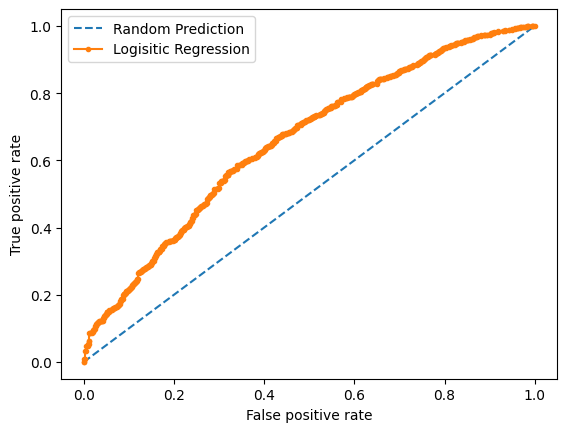

In [17]:
# Calculate the receiver operating curve and the AUC measure
lr_prob=lgstc_regScale.predict_proba(x_testScale)
lr_prob=lr_prob[:,1]

ns_prob=[0 for _ in range(len(y_test))]
ns_auc=roc_auc_score(y_test,ns_prob)
lr_auc=roc_auc_score(y_test,lr_prob)

print(f"AUC Random Predictions = {ns_auc}")
print(f"AUC predictions from logistic regression model = {lr_auc}")

ns_fpr,ns_tpr,_=roc_curve(y_test,ns_prob)
lr_fpr,lr_tpr,_=roc_curve(y_test,lr_prob)

plt.plot(ns_fpr,ns_tpr,linestyle="--",label="Random Prediction")
plt.plot(lr_fpr,lr_tpr,marker=".",label="Logisitic Regression")

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.show()
